In [1]:
# make some imports 
import warnings
warnings.filterwarnings("ignore")  # hide some annoying deprication warnings

import numpy as np
import pandas as pd

import random

random.seed(11)

In [2]:
# Load data

from sktime.datasets import load_UCR_UEA_dataset
from sklearn.metrics import accuracy_score

dataset = "BME"
X_train, Y_train = load_UCR_UEA_dataset(name=dataset, split="train", return_X_y=True, return_type="numpy2d")
X_test, Y_test = load_UCR_UEA_dataset(name=dataset, split="test", return_X_y=True, return_type="numpy2d")

print("Training data shape is", X_train.shape)

Training data shape is (30, 128)


In [3]:
import torch 
import torch.nn as nn
from notes import Transformer

In [4]:
# Convert data to tensors for the model and turn labels to one hot encoding from 0 - C - 1,
# where C is number of classes.

label_to_idx = {}
idx_to_label = {}
    
def data_converter(x, y, new=False):

    if new:
        for label in y:
            label_to_idx[label] = 0
        
        count = 0
        for label in label_to_idx:
            label_to_idx[label] = count
            idx_to_label[count] = label
            count += 1
        
    x = torch.Tensor(x)

    y = np.array([label_to_idx[l] for l in y])

    y = torch.Tensor(y).type(torch.LongTensor)

    return x, y
    
x_train, y_train = data_converter(X_train, Y_train, True)
x_test, y_test = data_converter(X_test, Y_test)

n_seq, n_feat = x_train.shape 

In [5]:
model = Transformer(n_feat=n_feat, seq_len=n_seq, n_classes=3)
model.fit(x_train, y_train, n_epochs=200)

In [7]:
# evaluate model at end of epoch
model.evaluate(x_test, y_test)

0.8866666555404663

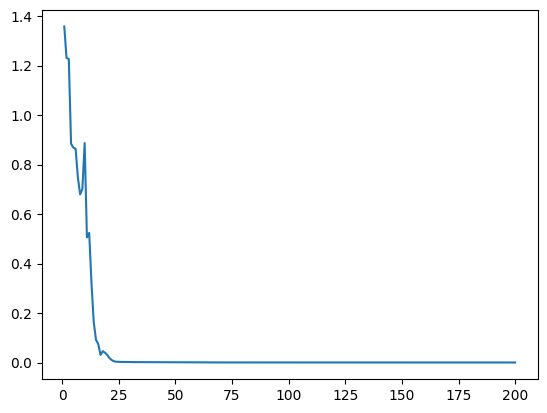

In [8]:
import matplotlib.pyplot as plt
epochs = [i+1 for i in range(model.n_epochs)]

plt.plot(epochs, model.train_loss_curve)

In [9]:
# Create a subset of the training data to be augmented

from copy import deepcopy

N = X_train.shape[0]
p = 0.2    # percentage of data to augment
rows_to_augment = random.sample(range(0,N), int(N*p))

X_subset = deepcopy(X_train[rows_to_augment,:])
y_subset = deepcopy(Y_train[rows_to_augment])


In [12]:
from surrogate_augmentation import correlated_noise_surrogates, AAFT_surrogates, refined_AAFT_surrogates

# Correlated noise surrogate
X_subset_augmented = correlated_noise_surrogates(X_subset)
X_train_augmented = np.concatenate((X_train, X_subset_augmented))
y_train_augmented = np.concatenate((Y_train, y_subset))

In [13]:
# Convert data to tensors for the model
 
x_train, y_train = data_converter(X_train_augmented, y_train_augmented, True)
n_seq, n_feat = x_train.shape 

In [14]:
x_train.shape

torch.Size([36, 128])

In [15]:
y_train.shape

torch.Size([36])

In [16]:
model = Transformer(n_feat=n_feat, seq_len=n_seq, n_classes=3)
model.fit(x_train, y_train)

In [17]:
# evaluate model at end of epoch
model.evaluate(x_test, y_test)

0.9200000166893005